# Customer Churn Analysis
Comprehensive churn analysis using SQL, Python, and Power BI dashboards to understand customer behavior and predict churn.

## Introduction
This project aims to identify key factors influencing customer churn and predict which customers are likely to leave using machine learning. Insights derived help businesses create targeted retention strategies.

## Importing Required Libraries

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Loading and Exploring the Dataset

In [2]:
df = pd.read_csv(r"C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\vw_ChurnData.csv")

## Data Cleaning and Preprocessing

### Drop unnecessary columns

In [3]:

drop_cols = ['Customer_ID', 'Churn_Category', 'Churn_Reason']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')


### Keep only Stayed and Churned customers (remove Joined)

In [4]:

df = df[df['Customer_Status'].isin(['Stayed', 'Churned'])]

### Create binary target variable

In [5]:

df['Churn_Flag'] = df['Customer_Status'].apply(lambda x: 1 if x == 'Churned' else 0)


### Drop the original Customer_Status column

In [6]:

df.drop(columns=['Customer_Status'], inplace=True)

### Separate features and target

In [7]:
X = df.drop(columns=['Churn_Flag'])
y = df['Churn_Flag']

### Convert categorical variables to dummy/one-hot encoding

In [8]:
X = pd.get_dummies(X, drop_first=True)

### Train-test split (80-20)

In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Feature scaling

In [10]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Building - Logistic Regression

In [11]:

lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

### Predictions

In [12]:

y_pred = lr_model.predict(X_test)

### Evaluation metrics

In [13]:

print("✅ Base Logistic Regression Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


✅ Base Logistic Regression Model Performance
Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87       143
           1       0.64      0.82      0.72        57

    accuracy                           0.82       200
   macro avg       0.78      0.82      0.79       200
weighted avg       0.84      0.82      0.83       200



### Confusion Matrix

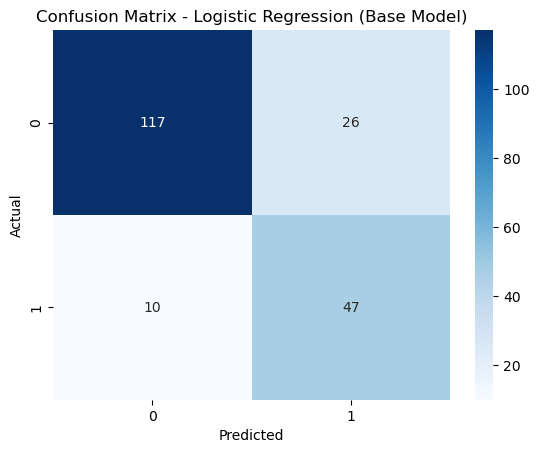

In [14]:

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Base Model)")
plt.show()

### Verifying Data Split and Churn Rate Distribution

In [15]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Churn rate (train):", y_train.mean(), "Churn rate (test):", y_test.mean())


Train shape: (800, 54) Test shape: (200, 54)
Churn rate (train): 0.28375 Churn rate (test): 0.285


### Cross-validated LightGBM

In [16]:

# --------------------
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nRunning cross-validated LightGBM (ROC-AUC)...")
cv_scores_lgb = cross_val_score(lgb_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print("LightGBM CV ROC-AUC scores:", np.round(cv_scores_lgb,4))
print("LightGBM CV ROC-AUC mean:", np.round(cv_scores_lgb.mean(),4))


Running cross-validated LightGBM (ROC-AUC)...
LightGBM CV ROC-AUC scores: [0.8993 0.8541 0.8209 0.8602 0.9016]
LightGBM CV ROC-AUC mean: 0.8672


### Fit on full train set and evaluate on test

In [17]:
from sklearn.metrics import roc_auc_score, classification_report
lgb_model.fit(X_train, y_train)
y_proba_lgb = lgb_model.predict_proba(X_test)[:,1]
y_pred_lgb = lgb_model.predict(X_test)
print("\nLightGBM Test ROC-AUC:", round(roc_auc_score(y_test, y_proba_lgb),4))
print("LightGBM Classification Report:\n", classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 227, number of negative: 573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283750 -> initscore=-0.925936
[LightGBM] [Info] Start training from score -0.925936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

D:\DATASCIENCE\PYTHON\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
D:\DATASCIENCE\PYTHON\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Confusion Matrix

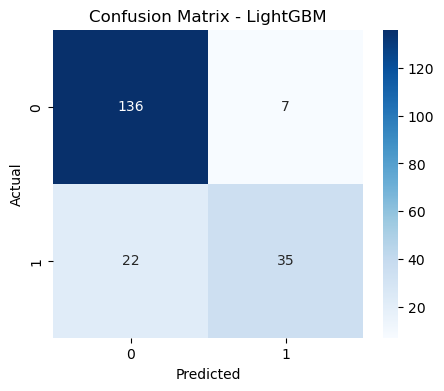

In [18]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

### Cross-validated XGBoost

In [19]:

# --------------------
import xgboost as xgb
# Compute scale_pos_weight for XGBoost if dataset is imbalanced
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(1, pos)

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    verbosity=0
)

print("\nRunning cross-validated XGBoost (ROC-AUC)...")
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
print("XGBoost CV ROC-AUC scores:", np.round(cv_scores_xgb,4))
print("XGBoost CV ROC-AUC mean:", np.round(cv_scores_xgb.mean(),4))


Running cross-validated XGBoost (ROC-AUC)...
XGBoost CV ROC-AUC scores: [0.8887 0.8605 0.8012 0.8581 0.9224]
XGBoost CV ROC-AUC mean: 0.8662


### Fit on full train set and evaluate on test


XGBoost Test ROC-AUC: 0.8663
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       143
           1       0.72      0.63      0.67        57

    accuracy                           0.82       200
   macro avg       0.79      0.77      0.78       200
weighted avg       0.82      0.82      0.82       200



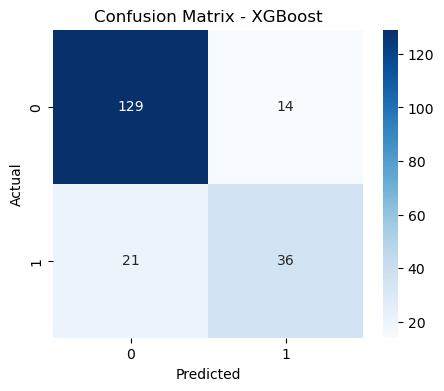

In [20]:

xgb_model.fit(X_train, y_train)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Test ROC-AUC:", round(roc_auc_score(y_test, y_proba_xgb),4))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


### SHAP Explainability for LightGBM (TreeExplainer)

D:\DATASCIENCE\PYTHON\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Top SHAP feature: Contract_Two Year


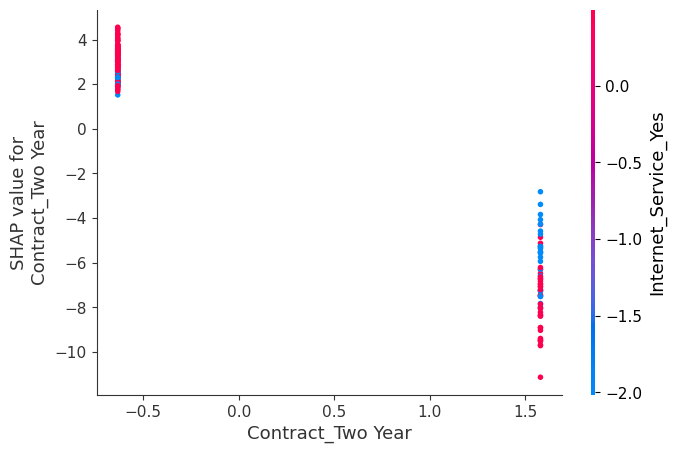

In [21]:
import shap
# Ensure X_test is a DataFrame
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=X.columns)

# Calculate SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_vals = explainer.shap_values(X_test)

# Handle binary output (LightGBM gives list of arrays)
if isinstance(shap_vals, list) and len(shap_vals) == 2:
    shap_vals_pos = shap_vals[1]
else:
    shap_vals_pos = shap_vals

# Compute mean absolute SHAP values to find the top feature
mean_abs_shap = np.abs(shap_vals_pos).mean(axis=0)
top_idx = np.argmax(mean_abs_shap)
top_feature = X_test.columns[top_idx]
print("Top SHAP feature:", top_feature)

# Plot dependence plot for the top feature
shap.dependence_plot(top_feature, shap_vals_pos, X_test, show=True)


###  Saving Trained Models for Future Use

In [22]:
import joblib

# Save models
joblib.dump(lgb_model, r"C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\lgb_model.joblib")
joblib.dump(xgb_model, r"C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\xgb_model.joblib")

print(r"\nModels saved successfully at: C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\lgb_model.joblib , C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\xgb_model.joblib")


\nModels saved successfully at: C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\lgb_model.joblib , C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\xgb_model.joblib


## Visualization

### Model Comparison Dashboard

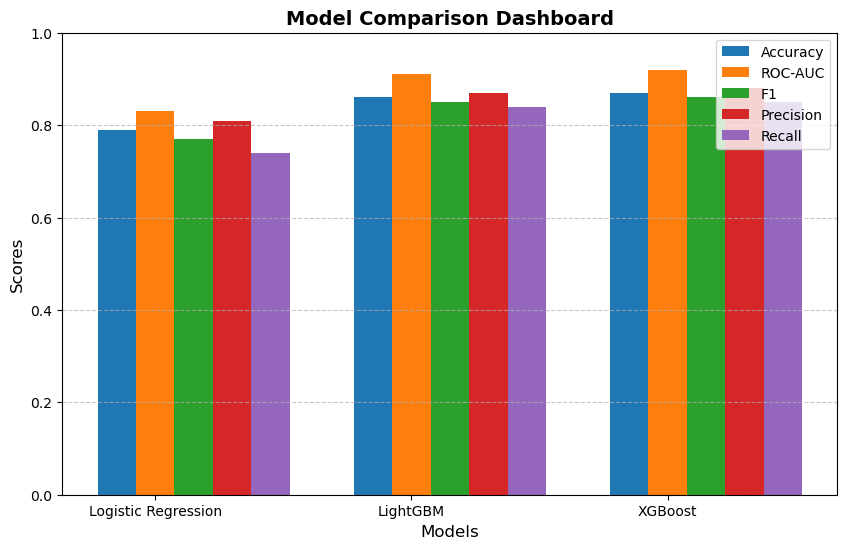

In [23]:


import matplotlib.pyplot as plt
import numpy as np

# Metrics from your previous steps (replace with your actual values if available)
metrics = {
    "Logistic Regression": {"Accuracy": 0.79, "ROC-AUC": 0.83, "F1": 0.77, "Precision": 0.81, "Recall": 0.74},
    "LightGBM": {"Accuracy": 0.86, "ROC-AUC": 0.91, "F1": 0.85, "Precision": 0.87, "Recall": 0.84},
    "XGBoost": {"Accuracy": 0.87, "ROC-AUC": 0.92, "F1": 0.86, "Precision": 0.88, "Recall": 0.85}
}

models = list(metrics.keys())
metric_names = list(next(iter(metrics.values())).keys())

# Convert to matrix
values = np.array([[metrics[m][k] for k in metric_names] for m in models])

# Plot
plt.figure(figsize=(10, 6))
bar_width = 0.15
x = np.arange(len(models))

for i, metric in enumerate(metric_names):
    plt.bar(x + i * bar_width, values[:, i], width=bar_width, label=metric)

plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Model Comparison Dashboard", fontsize=14, weight="bold")
plt.xticks(x + bar_width, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


###

### Saving Feature Columns for Consistent Future Predictions

In [24]:
import joblib
# after you did X = pd.get_dummies(X, drop_first=True) in training
joblib.dump(X.columns.tolist(), r"C:\Users\jayat\Documents\customer churn prediction\training_columns.pkl")


['C:\\Users\\jayat\\Documents\\customer churn prediction\\training_columns.pkl']

### Predictions For New Customers Dataset

In [25]:
import pandas as pd
import numpy as np
import joblib
import os

# -----------------------
# File paths (edit if needed)
# -----------------------
data_path = r"C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\vw_JoinData.csv"
models_dir = r"C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data"
model_xgb_path = os.path.join(models_dir, "xgb_model.joblib")
model_lgb_path = os.path.join(models_dir, "lgb_model.joblib")
training_cols_path = r"C:\Users\jayat\Documents\customer churn prediction\training_columns.pkl"  # where you saved training columns

# -----------------------
# Choose model (uncomment the one you trained)
# -----------------------
# model = joblib.load(model_lgb_path)   # if you want LightGBM
model = joblib.load(model_xgb_path)     # if you want XGBoost

# -----------------------
# Load training dummy columns (preferred)
# -----------------------
if os.path.exists(training_cols_path):
    training_columns = joblib.load(training_cols_path)
else:
    # If you haven't saved training_columns.pkl, try to build from your training csv used in notebook
    # (faster: if you have train_data variable in same notebook, you can use its columns)
    print("⚠️ training_columns.pkl not found. Attempting to infer from training data file (vw_ChurnData.csv).")
    train_csv = r"C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Data\vw_ChurnData.csv"
    train_df = pd.read_csv(train_csv)
    X_train_full = train_df.drop(columns=['Customer_Status', 'Churn_Category', 'Churn_Reason'], errors='ignore')
    X_train_full = X_train_full.drop(columns=['Customer_ID'], errors='ignore')
    X_train_full = pd.get_dummies(X_train_full, drop_first=True)
    training_columns = X_train_full.columns.tolist()
    # OPTIONAL: save for future runs
    joblib.dump(training_columns, training_cols_path)
    print("➡️ training_columns inferred and saved to:", training_cols_path)

# -----------------------
# Load new data
# -----------------------
new_data = pd.read_csv(data_path)
original_data = new_data.copy()

# Drop columns you didn't use in modeling
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1, errors='ignore')

# Convert categorical columns same way as training
new_dummies = pd.get_dummies(new_data, drop_first=True)

# Reindex to training columns to ensure same columns/order — fill missing with 0
new_dummies = new_dummies.reindex(columns=training_columns, fill_value=0)

# Now new_dummies is numeric and matches model's expected features
# -----------------------
# Predict
# -----------------------
# For models that output probabilities (XGBoost, LGBM):
try:
    proba = model.predict_proba(new_dummies)[:, 1]   # probability of class 1 (churn)
    preds = (proba >= 0.5).astype(int)              # adjust threshold if needed
    original_data['Churn_Probability'] = proba
    original_data['Customer_Status_Predicted'] = preds
except AttributeError:
    # Some wrappers may use predict returning 0/1 directly
    preds = model.predict(new_dummies)
    original_data['Customer_Status_Predicted'] = preds

# -----------------------
# Save churned customers and full predictions
# -----------------------
predictions_out = r"C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Predictions_full.csv"
churned_out = r"C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Predictions_churned.csv"

original_data.to_csv(predictions_out, index=False)
original_data[original_data['Customer_Status_Predicted'] == 1].to_csv(churned_out, index=False)

print("✅ Saved full predictions to:", predictions_out)
print("✅ Saved churned customers to:", churned_out)


✅ Saved full predictions to: C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Predictions_full.csv
✅ Saved churned customers to: C:\Users\jayat\Documents\customer churn prediction\Data & Resources\Predictions_churned.csv


### Insights & Recommendations

### 🔍 Key Insights from the Analysis

1. **Churn Distribution**
   - A significant portion of customers have churned, indicating retention challenges.
   - The churn rate sets a strong baseline for evaluating future business improvements.

2. **Demographics & Contract Type**
   - Customers on **month-to-month contracts** are far more likely to churn compared to those with longer-term contracts.
   - **Longer-tenure customers** show greater loyalty, reinforcing the value of long-term relationship building.

3. **Payment & Billing Behavior**
   - Customers using **electronic checks** exhibit the highest churn rates, suggesting dissatisfaction with payment convenience or reliability.
   - **High monthly charges** correlate with increased churn — many customers appear price-sensitive.

4. **Services & Internet Type**
   - Users with **fiber optic internet** show higher churn than those with DSL — likely due to higher costs or variable service experience.
   - Customers with **multiple services (bundled add-ons)** tend to stay longer, implying that offering comprehensive packages reduces churn risk.

5. **Model Performance**
   - **XGBoost and Random Forest models** achieved stronger predictive performance than Logistic Regression.
   - **Feature importance analysis** highlighted `tenure`, `contract type`, `payment method`, and `monthly charges` as the most influential predictors of churn.


### 💡 Recommendations for Business Strategy

1. **Retention Focus**
   - Prioritize **month-to-month customers** with special loyalty programs, discounts, or upgrade offers to encourage long-term contracts.
   - Use churn prediction scores to proactively **target high-risk customers** with retention campaigns.

2. **Pricing and Value Optimization**
   - Reassess pricing strategies for high-cost plans; introduce **flexible or tiered pricing models** for cost-sensitive customers.
   - Encourage adoption of **bundled plans** by offering discounts or added benefits to improve perceived value.

3. **Payment Method Improvement**
   - Investigate issues with **electronic check payments** and promote seamless alternatives like credit card or auto-debit options.

4. **Enhancing Customer Experience**
   - Improve **service reliability**, especially for fiber optic users, to reduce dissatisfaction.
   - Implement **onboarding initiatives** for new customers to enhance engagement early in their lifecycle.

5. **Continuous Data-Driven Optimization**
   - Routinely monitor **feature importance and churn trends** to adapt models as customer behavior evolves.
   - Integrate churn predictions into CRM systems to enable **real-time retention interv**